In [1]:
import networkx as nx

Number of nodes (club members) 34
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


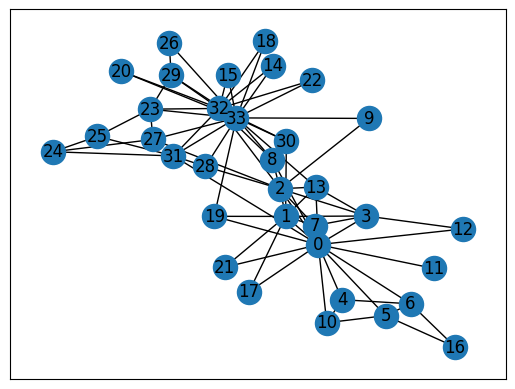

In [2]:
# Working with karate club datset
G = nx.karate_club_graph()
print("Number of nodes (club members)", len(G.nodes))
nx.draw_networkx(G)

In [6]:
# Plot the graph with labels
# There are two labels for this dataset
# 1. officer 2. Mr.Hi
labels = []
for n in G.nodes:
    club_name = G.nodes[n]['club']
    labels.append(1 if club_name == "Officer" else 0)

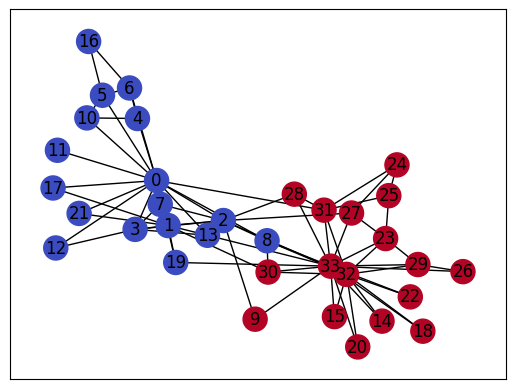

In [7]:
# Plot graph with labels
layout_pos = nx.spring_layout(G)
nx.draw_networkx(G, pos=layout_pos, node_color=labels, cmap="coolwarm")

In [11]:
import numpy as np

In [12]:
# Deepwalk from scratch implementation

def random_walk(graph, node, walk_length):
    walk = [node]

    for _ in range(walk_length-1):
        neighbors = list(graph.neighbors(walk[-1]))

        if len(neighbors) == 0:
            break
        random_node = np.random.choice(neighbors)
        walk.append(random_node)
    return walk


def generate_all_walks(graph, num_walks, walk_length):
    walks = []
    nodes = list(graph.nodes())
    for _ in range(num_walks):
        np.random.shuffle(nodes)
        for node in nodes:
            walks.append(random_walk(graph, node, walk_length))
    return walks

In [14]:
walks = generate_all_walks(G, num_walks=10, walk_length=20)

In [16]:
from gensim.models import Word2Vec

In [17]:
#Learning embeding with Word2Vec model
# In order to learn embeddings we need to convert the walks in list of strings

def learn_embeddings(walks, dimensions, window_size, workers=4):
    walks = [[str(node) for node in walk] for walk in walks]
    model = Word2Vec(walks, vector_size=dimensions, window=window_size, min_count=0, sg=1, workers=workers)
    return model

In [18]:
model = learn_embeddings(walks, dimensions=64, window_size=5)

In [27]:
# Extracting embeddings from the model
embeddings = np.array([model.wv[str(node)] for node in G.nodes()])

In [28]:
embeddings.shape #(nodes x features)

(34, 64)

In [29]:
# Visualizing the embeddings in low dim
import sklearn
import matplotlib.pyplot as plt

In [33]:
pca_model = sklearn.decomposition.PCA(2)

In [34]:
low_dim_embed = pca_model.fit_transform(embeddings)
print("low dim in shape", low_dim_embed.shape)

low dim in shape (34, 2)


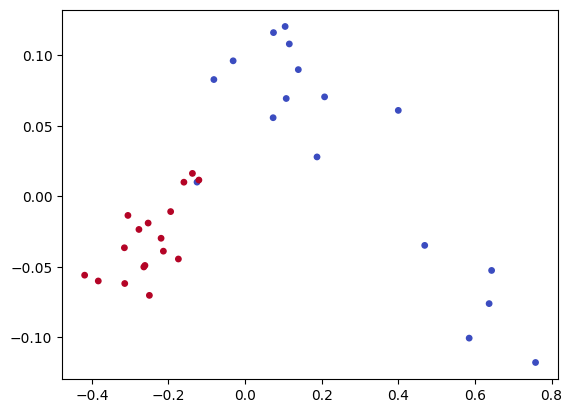

In [36]:
plt.scatter(low_dim_embed[:, 0], low_dim_embed[:, 1], c=labels, 
            s=15, cmap="coolwarm")

In [37]:
# Next we will do the node classification with logistic regression
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

In [39]:
x_train, x_test, y_train, y_test = train_test_split(embeddings, labels, test_size=0.3)
clf_model = LogisticRegression(random_state=0).fit(x_train, y_train)
y_predict = clf_model.predict(x_test)

auc = roc_auc_score(y_test, y_predict)
print("AUC", round(auc, 4))


AUC 0.9
